In [1]:
import sys

## !pip install -e ../gym_space_docking/

loc = os.popen('pip3 show gym_space_docking').readlines()[7].split()[1]


sys.path.append(loc)


import gym
import os
import gym_space_docking

In [2]:
# include Network
import numpy as np
import tensorflow as tf

from tensorflow import keras
#from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average, Bidirectional
from tensorflow.keras import layers

2022-02-01 07:45:56.759998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-01 07:45:56.760023: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
env = gym.make('space_docking-v0')
#env = gym.wrappers.Monitor(env, 'recording')
r = env.reset()

pygame 2.1.0 (SDL 2.0.16, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
/home/meyd/Documents/GitHub/Denny-Meyer/IronHack_Final_Project/gym_space_docking/gym_space_docking/envs


In [4]:
map, reward, done, info = env.step(0)
    

In [5]:
#map.reshape(88,80,3)

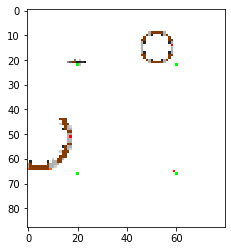

In [6]:
from matplotlib import pyplot as plt
plt.imshow(map, interpolation='nearest')
plt.show()

In [7]:
num_actions = env.action_space.n


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(88, 80, 3,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

In [8]:
#model = keras.models.load_model('train_model')
#model_target = keras.models.load_model('target_model')

In [9]:
model = create_q_model()
model_target = create_q_model()

2022-02-01 07:45:59.162276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 07:45:59.162707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-01 07:45:59.162788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-01 07:45:59.162858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

In [10]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

In [11]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 5000 # old + 0
# Number of frames for exploration
epsilon_greedy_frames = 100000.0 # old + 0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 200000 # old 100000
# Train the model after 4 actions
update_after_actions = 2
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

#loss
loss = 0.0


# write points to files

file_rewards = open('rewards.txt', 'a')
file_epsilon = open('epsilon.txt', 'a')
file_loss = open('loss.txt', 'a') 


while True:  # Run until solved
    state = np.array(env.reset()[0])
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)


        #plt.imshow(state_next, interpolation='nearest')
        #plt.show()
        #print(reward)
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            #print(state_sample)
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )


            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            
            file_rewards.write(str(rewards_history[-1]) + '\n')
            file_epsilon.write(str(epsilon) + '\n')
            file_loss.write(str(loss) + '\n')
            file_rewards.flush()
            file_epsilon.flush()
            file_loss.flush()
            print(rewards_history[-1])
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if episode_count % 50 == 0:

        model.compile(optimizer=optimizer, loss=loss_function)
        model_target.compile(optimizer=optimizer, loss=loss_function)
        model.save('train_model')
        model_target.save('target_model')

    if running_reward > 10000000:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

-6.589536001201191
-4.986801306957844
-23.275345627369553
-61.430125473000864
-9.423999669530502
588.7173640771682
450.56698168111376
-40.54885984605055


KeyboardInterrupt: 